In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import pickle

In [39]:
with open('saved_metrics/all_metrics.pkl', 'rb') as f:
    all_metrics = pickle.load(f)

with open('saved_finetuned_metrics/all_finetuned_metrics.pkl', 'rb') as f:
    all_finetuned_metrics = pickle.load(f)

df_normal_test_power = pd.read_csv('saved_metrics/normal_models_test_power.csv')

df_finetuned_test_power = pd.read_csv('saved_finetuned_metrics/finetuned_models_test_power.csv')

df_tflite_normal_no_quant_cpu = pd.read_csv('converted_metrics/tflite_normal_no_quant_cpu_results.csv')
df_tflite_normal_no_quant_gpu = pd.read_csv('converted_metrics/tflite_normal_no_quant_gpu_results.csv')
df_tflite_normal_int8 = pd.read_csv('converted_metrics/tflite_normal_int8_results.csv')
df_tflite_finetuned_no_quant_cpu = pd.read_csv('converted_metrics/tflite_finetuned_no_quant_cpu_results.csv')
df_tflite_finetuned_no_quant_gpu = pd.read_csv('converted_metrics/tflite_finetuned_no_quant_gpu_results.csv')
df_tflite_finetuned_int8 = pd.read_csv('converted_metrics/tflite_finetuned_int8_results.csv')

print(f"Loaded {len(all_metrics)} trained models")
print(f"Loaded {len(all_finetuned_metrics)} fine-tuned models")
print(f"Loaded test power data for normal and fine-tuned models")
print(f"Loaded TFLite evaluation results")

Loaded 10 trained models
Loaded 10 fine-tuned models
Loaded test power data for normal and fine-tuned models
Loaded TFLite evaluation results


In [48]:
def extract_test_cpu_energy_by_model(df_test_power):
    """Extract CPU energy per model from test power measurements."""
    energy_by_model = {}
    for model in df_test_power['model'].unique():
        model_data = df_test_power[df_test_power['model'] == model]
        cpu_energy = model_data['cpu_energy_wh'].sum()
        energy_by_model[model] = cpu_energy
    return energy_by_model

def extract_test_gpu_energy_by_model(df_test_power):
    """Extract GPU energy per model from test power measurements."""
    energy_by_model = {}
    for model in df_test_power['model'].unique():
        model_data = df_test_power[df_test_power['model'] == model]
        gpu_energy = model_data['gpu_energy_wh'].sum()
        energy_by_model[model] = gpu_energy
    return energy_by_model

def extract_tflite_accuracy_by_model(df_tflite):
    """Extract accuracy per model from TFLite results."""
    accuracy_by_model = {}
    for model in df_tflite['model'].unique():
        model_data = df_tflite[df_tflite['model'] == model]
        accuracy_by_model[model] = model_data['accuracy'].values
    return accuracy_by_model

def extract_test_accuracy_from_metrics(all_metrics):
    """Extract test accuracy from metrics."""
    accuracy_by_model = {}
    for metrics in all_metrics:
        model_name = metrics['model_name']
        accuracy_by_model[model_name] = np.array(metrics['test_acc'])
    return accuracy_by_model

def extract_test_f1_from_metrics(all_metrics):
    """Extract test F1 scores from metrics."""
    f1_by_model = {}
    for metrics in all_metrics:
        model_name = metrics['model_name']
        f1_by_model[model_name] = np.array(metrics['test_f1'])
    return f1_by_model

def extract_tflite_f1_by_model(df_tflite):
    """Extract F1 score per model from TFLite results."""
    f1_by_model = {}
    for model in df_tflite['model'].unique():
        model_data = df_tflite[df_tflite['model'] == model]
        f1_by_model[model] = model_data['f1_score'].values
    return f1_by_model

def extract_tflite_data_by_model(df_tflite):
    """Extract energy and accuracy per model from TFLite results."""
    energy_by_model = {}
    accuracy_by_model = {}
    
    for model in df_tflite['model'].unique():
        model_data = df_tflite[df_tflite['model'] == model]
        total_energy = model_data['energy_wh'].sum()
        if 'gpu_energy_wh' in model_data.columns:
            total_energy += model_data['gpu_energy_wh'].sum()
        
        energy_by_model[model] = total_energy
        accuracy_by_model[model] = model_data['accuracy'].values
    
    return energy_by_model, accuracy_by_model

In [41]:
def reorder_models(data_dict, custom_order=[1,5,2,3,6,4,7,8,9,10]):
    """Reorder models according to custom order, keeping data but with sequential display labels."""
    from collections import OrderedDict
    
    reordered_data = OrderedDict()
    
    for new_pos, orig_idx in enumerate(custom_order, start=1):
        orig_model = f'model_{orig_idx}'
        display_label = f'model_{new_pos}'
        
        if orig_model in data_dict:
            reordered_data[display_label] = data_dict[orig_model]
    
    return reordered_data

In [60]:
def create_energy_comparison_bar(data_dict, title, ylabel, figsize=(12, 6)):
    """Create bar chart comparing energy consumption across models."""
    models = sorted(data_dict.keys())
    energies = [data_dict[m] for m in models]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    bars = ax.bar(range(len(models)), energies, color='steelblue', alpha=0.7, edgecolor='black')
    
    for i, (bar, energy) in enumerate(zip(bars, energies)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{energy:.4f}',
                ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_side_by_side_comparison(data1, data2, label1, label2, title, ylabel, figsize=(14, 6)):
    """Create side-by-side bar comparison."""
    models = list(data1.keys())
    
    x = np.arange(len(models))
    width = 0.35
    
    values1 = [data1.get(m, 0) for m in models]
    values2 = [data2.get(m, 0) for m in models]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    bars1 = ax.bar(x - width/2, values1, width, label=label1, color='#1f77b4', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, values2, width, label=label2, color='#ff7f0e', alpha=0.7, edgecolor='black')
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}',
                        ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=30, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_accuracy_boxplot_comparison(acc_data1, acc_data2, label1, label2, title, ylabel='Accuracy (%)', figsize=(12, 6)):
    """Create boxplot comparing accuracy/F1-score distributions."""
    models = list(acc_data1.keys())
    
    plot_data = []
    positions = []
    colors = []
    
    gap = 0.3
    color1 = '#1f77b4'
    color2 = '#ff7f0e'
    
    for i, model in enumerate(models):
        if model in acc_data1:
            plot_data.append(acc_data1[model])
            positions.append(i * (2 + gap))
            colors.append(color1)
        
        if model in acc_data2:
            plot_data.append(acc_data2[model])
            positions.append(i * (2 + gap) + 0.8)
            colors.append(color2)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    bplot = ax.boxplot(
        plot_data,
        positions=positions,
        widths=0.7,
        patch_artist=True,
        showmeans=False,
        whis=[0, 100]
    )
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    for median in bplot['medians']:
        median.set_color('black')
        median.set_linewidth(2)
    
    x_ticks = [i * (2 + gap) + 0.4 for i in range(len(models))]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(models, rotation=30, ha='right', fontsize=10)
    
    ax.set_ylabel(ylabel, fontsize=12)  # Use the ylabel parameter
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color1, alpha=0.7, label=label1),
        Patch(facecolor=color2, alpha=0.7, label=label2)
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    return fig


GENERATING ENERGY COMPARISON VISUALIZATIONS

1. Comparing Normal vs Fine-tuned models (Test Energy)...


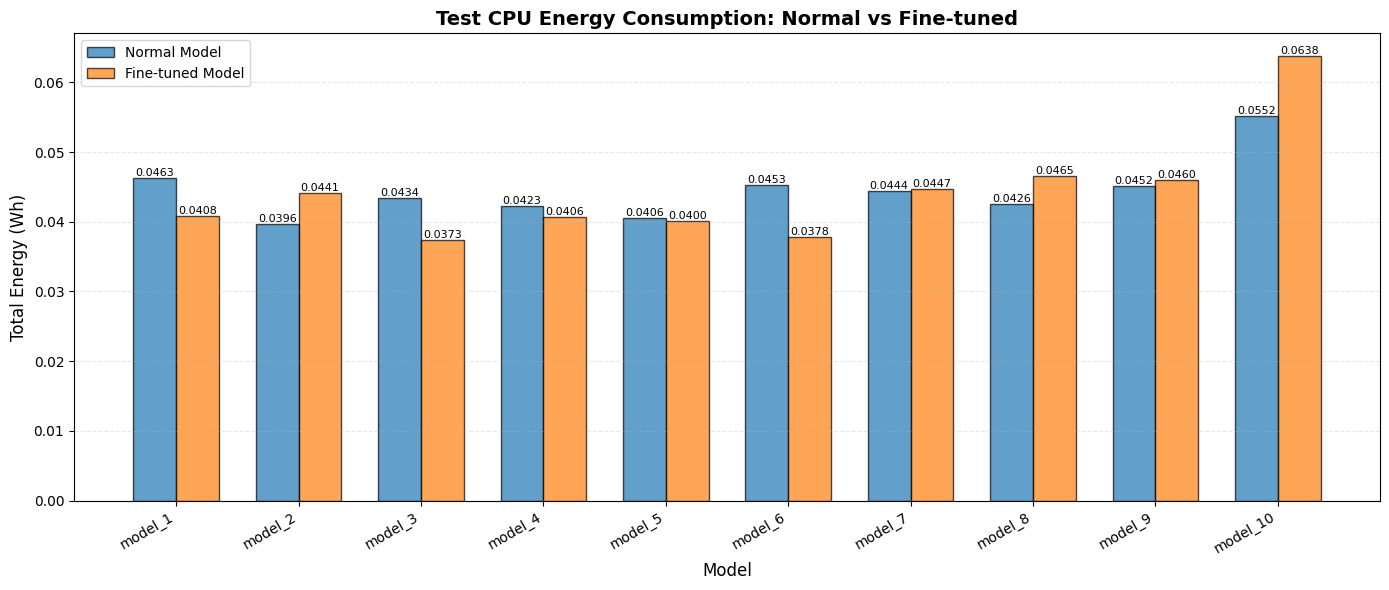

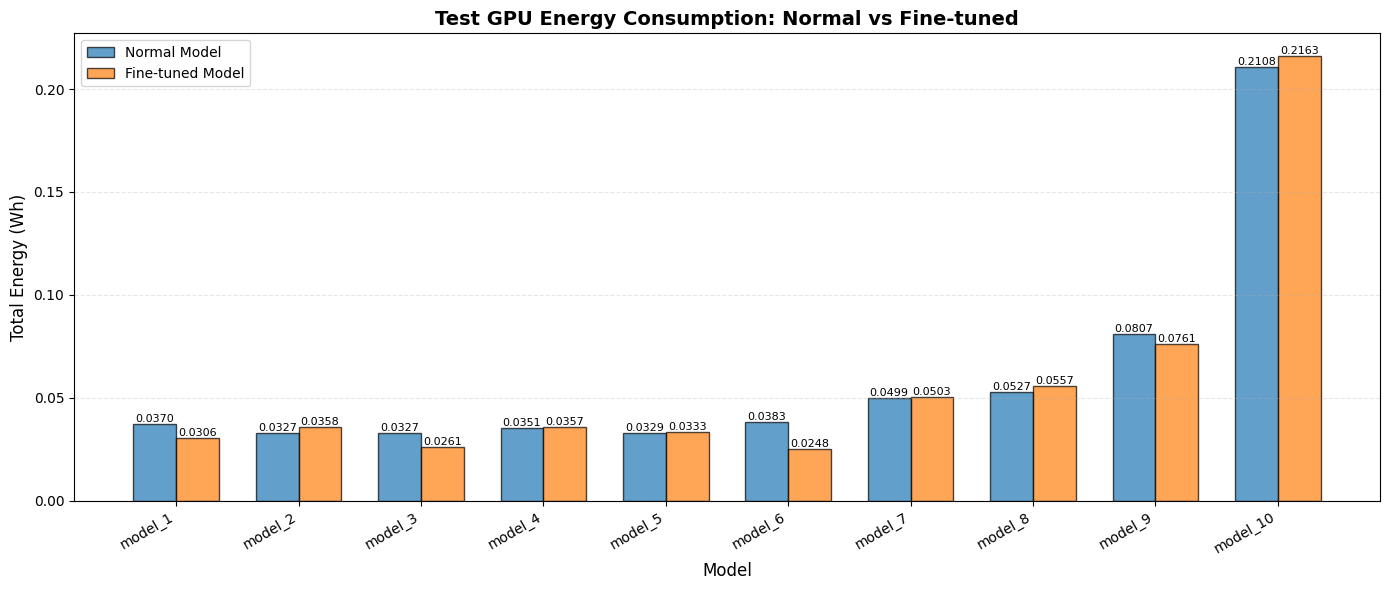

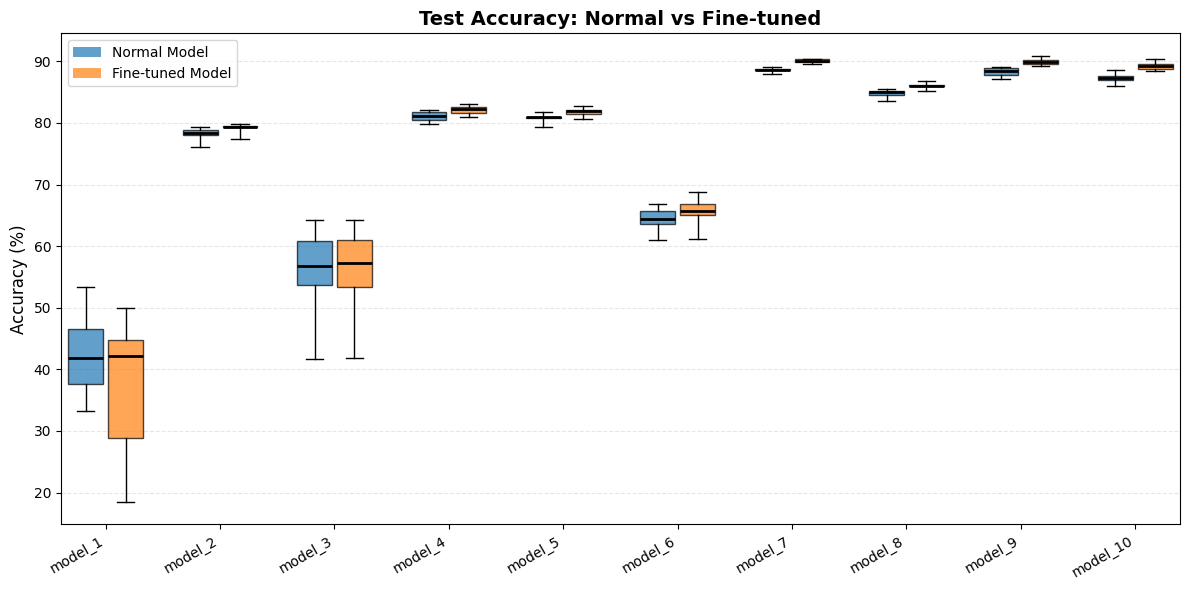

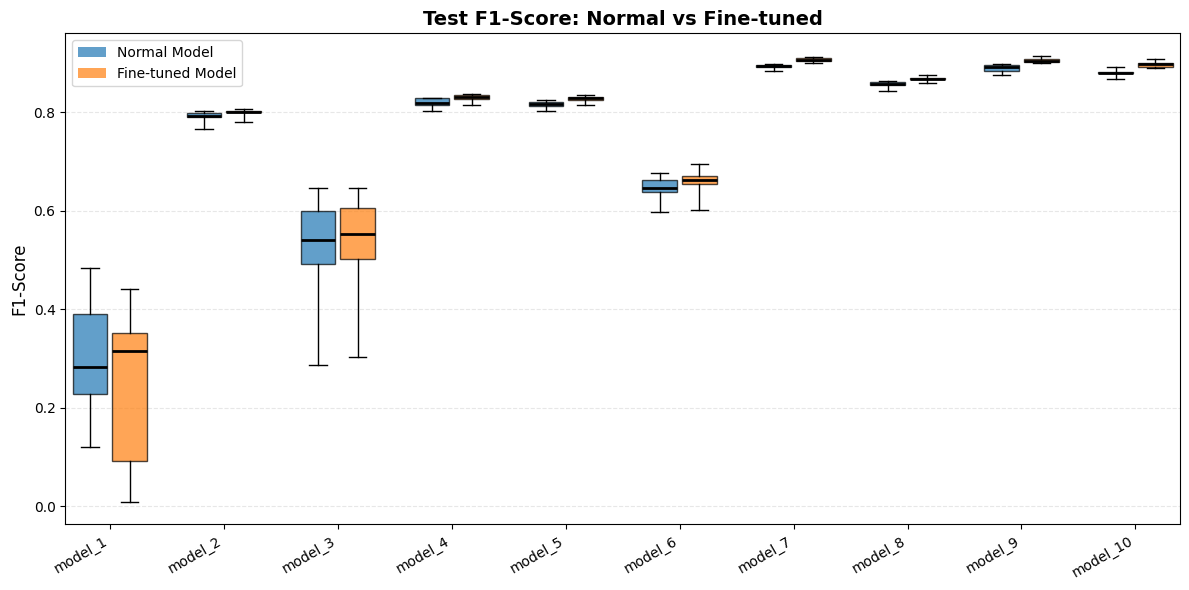

In [61]:
save_dir = 'figures/energy_comparisons'
os.makedirs(save_dir, exist_ok=True)

print("\n" + "="*80)
print("GENERATING ENERGY COMPARISON VISUALIZATIONS")
print("="*80 + "\n")

print("1. Comparing Normal vs Fine-tuned models (Test Energy)...")
normal_test_cpu_energy = extract_test_cpu_energy_by_model(df_normal_test_power)
normal_test_gpu_energy = extract_test_gpu_energy_by_model(df_normal_test_power)
finetuned_test_cpu_energy = extract_test_cpu_energy_by_model(df_finetuned_test_power)
finetuned_test_gpu_energy = extract_test_gpu_energy_by_model(df_finetuned_test_power)
normal_test_acc = extract_test_accuracy_from_metrics(all_metrics)
finetuned_test_acc = extract_test_accuracy_from_metrics(all_finetuned_metrics)
normal_test_f1 = extract_test_f1_from_metrics(all_metrics)
finetuned_test_f1 = extract_test_f1_from_metrics(all_finetuned_metrics)

CUSTOM_ORDER = [1,5,2,3,6,4,7,8,9,10]

normal_test_cpu_energy = reorder_models(normal_test_cpu_energy, CUSTOM_ORDER)
normal_test_gpu_energy = reorder_models(normal_test_gpu_energy, CUSTOM_ORDER)
finetuned_test_cpu_energy = reorder_models(finetuned_test_cpu_energy, CUSTOM_ORDER)
finetuned_test_gpu_energy = reorder_models(finetuned_test_gpu_energy, CUSTOM_ORDER)
normal_test_acc = reorder_models(normal_test_acc, CUSTOM_ORDER)
finetuned_test_acc = reorder_models(finetuned_test_acc, CUSTOM_ORDER)
normal_test_f1 = reorder_models(normal_test_f1, CUSTOM_ORDER)
finetuned_test_f1 = reorder_models(finetuned_test_f1, CUSTOM_ORDER)

fig1_cpu = create_side_by_side_comparison(
    normal_test_cpu_energy, finetuned_test_cpu_energy,
    'Normal Model', 'Fine-tuned Model',
    'Test CPU Energy Consumption: Normal vs Fine-tuned',
    'Total Energy (Wh)'
)
fig1_cpu.savefig(f'{save_dir}/1_normal_vs_finetuned_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig1_gpu = create_side_by_side_comparison(
    normal_test_gpu_energy, finetuned_test_gpu_energy,
    'Normal Model', 'Fine-tuned Model',
    'Test GPU Energy Consumption: Normal vs Fine-tuned',
    'Total Energy (Wh)'
)
fig1_gpu.savefig(f'{save_dir}/1_normal_vs_finetuned_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig1_acc = create_accuracy_boxplot_comparison(
    normal_test_acc, finetuned_test_acc,
    'Normal Model', 'Fine-tuned Model',
    'Test Accuracy: Normal vs Fine-tuned'
)
fig1_acc.savefig(f'{save_dir}/1_normal_vs_finetuned_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

fig1_f1 = create_accuracy_boxplot_comparison(
    normal_test_f1, finetuned_test_f1,
    'Normal Model', 'Fine-tuned Model',
    'Test F1-Score: Normal vs Fine-tuned',
    ylabel='F1-Score'
)
fig1_f1.savefig(f'{save_dir}/1_normal_vs_finetuned_f1.png', dpi=300, bbox_inches='tight')
plt.show()

2. Comparing Normal Keras vs TFLite No-Quant models...


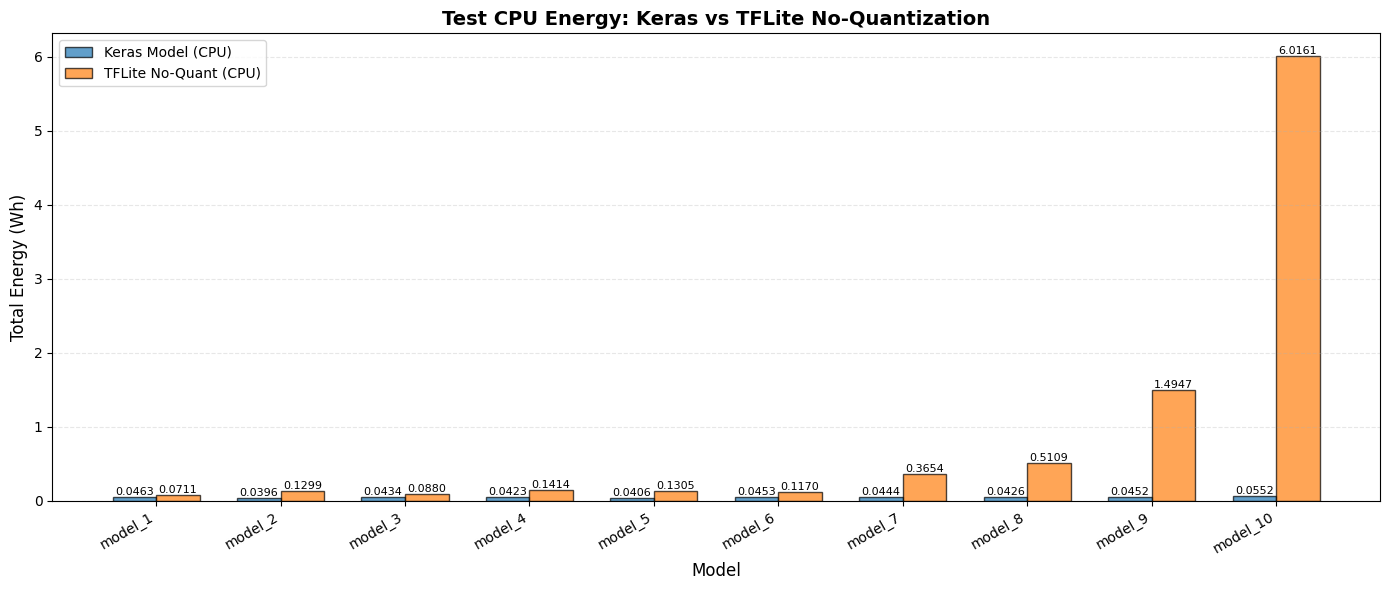

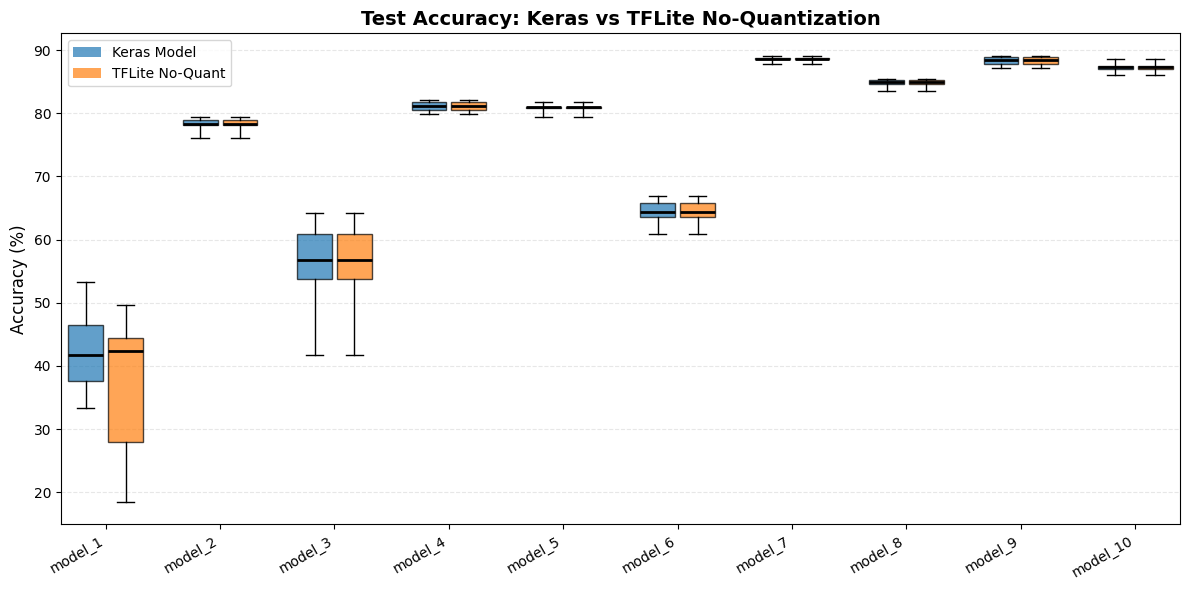

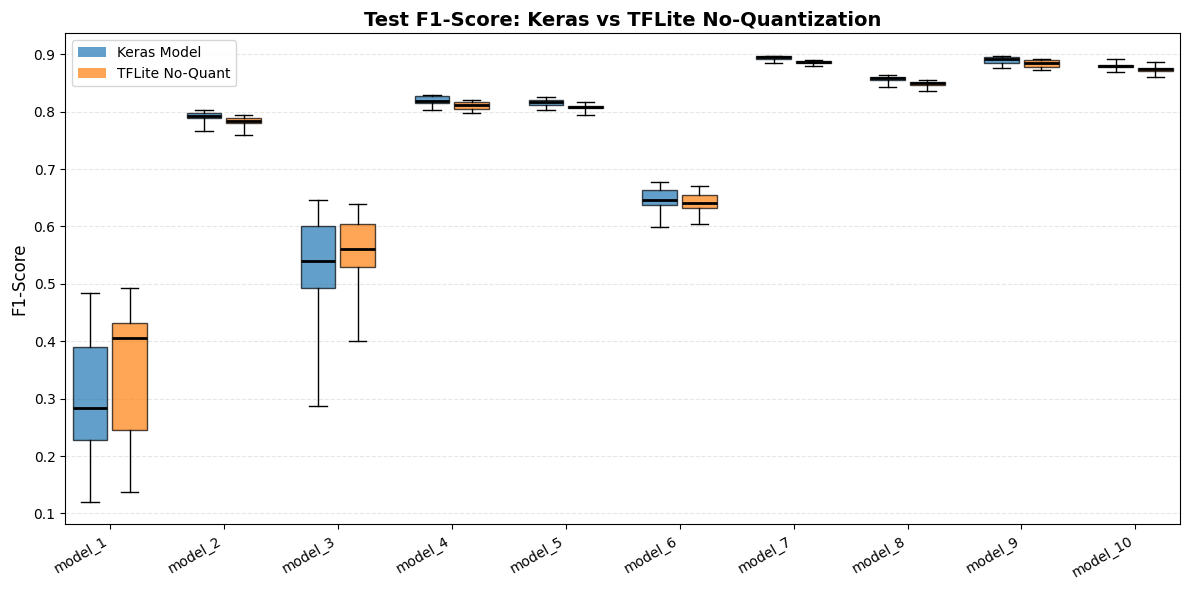

In [62]:
print("2. Comparing Normal Keras vs TFLite No-Quant models...")
tflite_no_quant_cpu_energy = extract_test_cpu_energy_by_model(df_tflite_normal_no_quant_cpu)
tflite_no_quant_cpu_acc = extract_tflite_accuracy_by_model(df_tflite_normal_no_quant_cpu)
tflite_no_quant_cpu_f1 = extract_tflite_f1_by_model(df_tflite_normal_no_quant_cpu)

tflite_no_quant_cpu_energy = reorder_models(tflite_no_quant_cpu_energy, CUSTOM_ORDER)
tflite_no_quant_cpu_acc = reorder_models(tflite_no_quant_cpu_acc, CUSTOM_ORDER)
tflite_no_quant_cpu_f1 = reorder_models(tflite_no_quant_cpu_f1, CUSTOM_ORDER)

fig2 = create_side_by_side_comparison(
    normal_test_cpu_energy, tflite_no_quant_cpu_energy,
    'Keras Model (CPU)', 'TFLite No-Quant (CPU)',
    'Test CPU Energy: Keras vs TFLite No-Quantization',
    'Total Energy (Wh)'
)
fig2.savefig(f'{save_dir}/2_keras_vs_tflite_noquant_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig2_acc = create_accuracy_boxplot_comparison(
    normal_test_acc, tflite_no_quant_cpu_acc,
    'Keras Model', 'TFLite No-Quant',
    'Test Accuracy: Keras vs TFLite No-Quantization'
)
fig2_acc.savefig(f'{save_dir}/2_keras_vs_tflite_noquant_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

fig2_f1 = create_accuracy_boxplot_comparison(
    normal_test_f1, tflite_no_quant_cpu_f1,
    'Keras Model', 'TFLite No-Quant',
    'Test F1-Score: Keras vs TFLite No-Quantization',
    ylabel='F1-Score'
)
fig2_f1.savefig(f'{save_dir}/2_keras_vs_tflite_noquant_f1.png', dpi=300, bbox_inches='tight')
plt.show()

3. Comparing Normal Keras vs TFLite INT8 models...


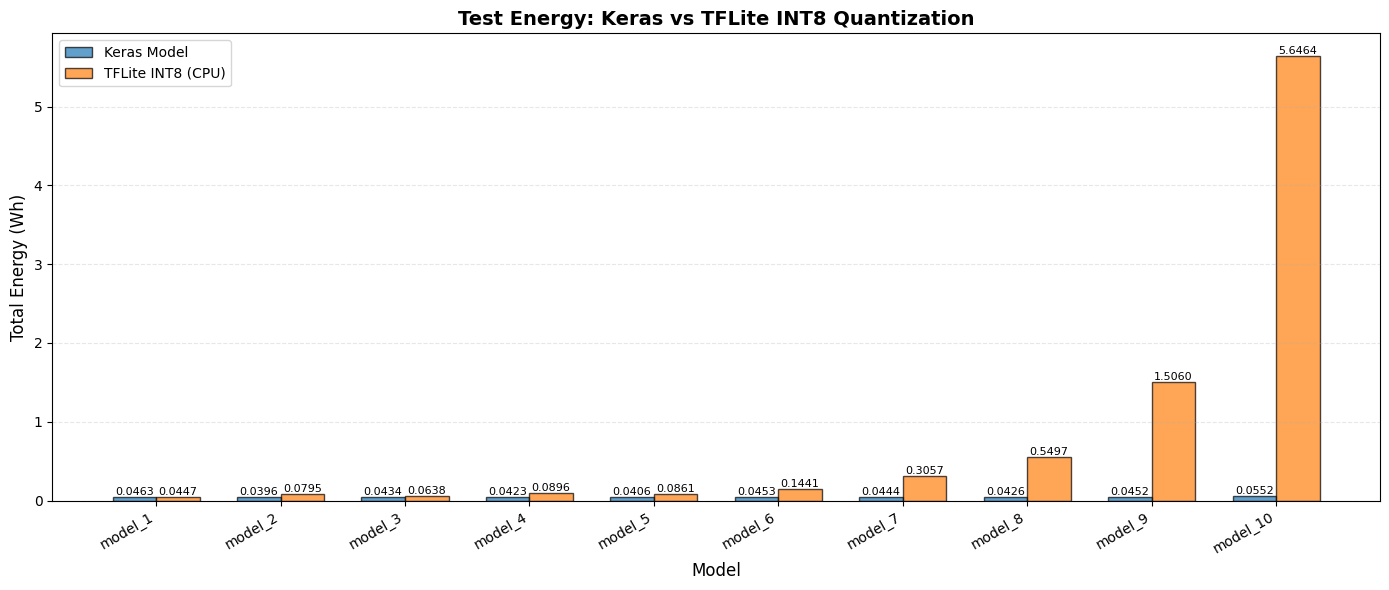

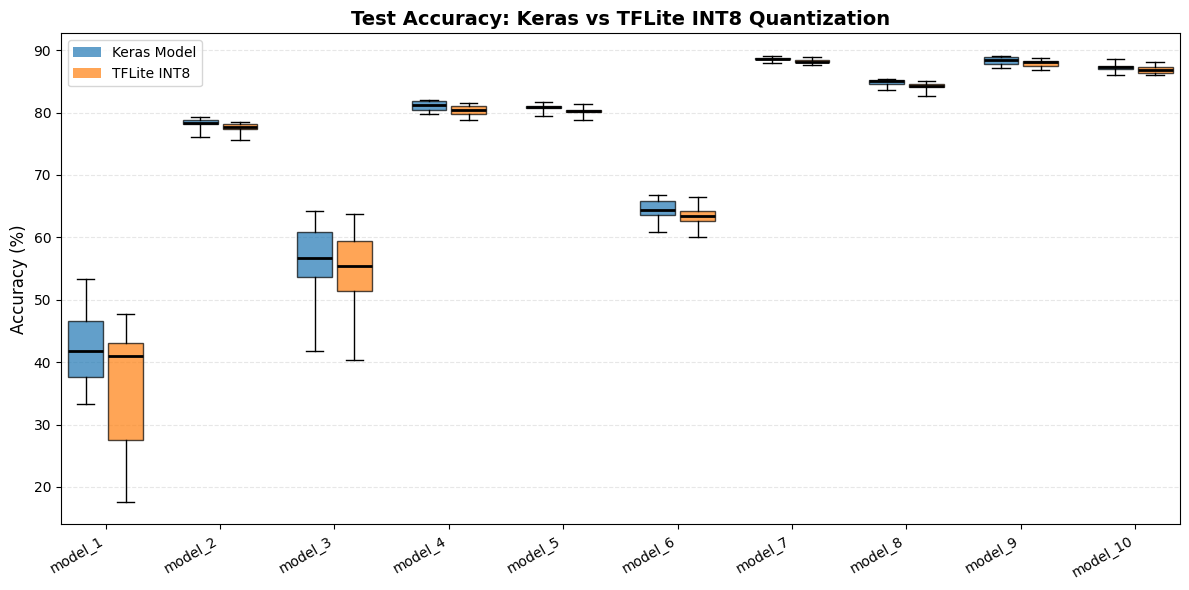

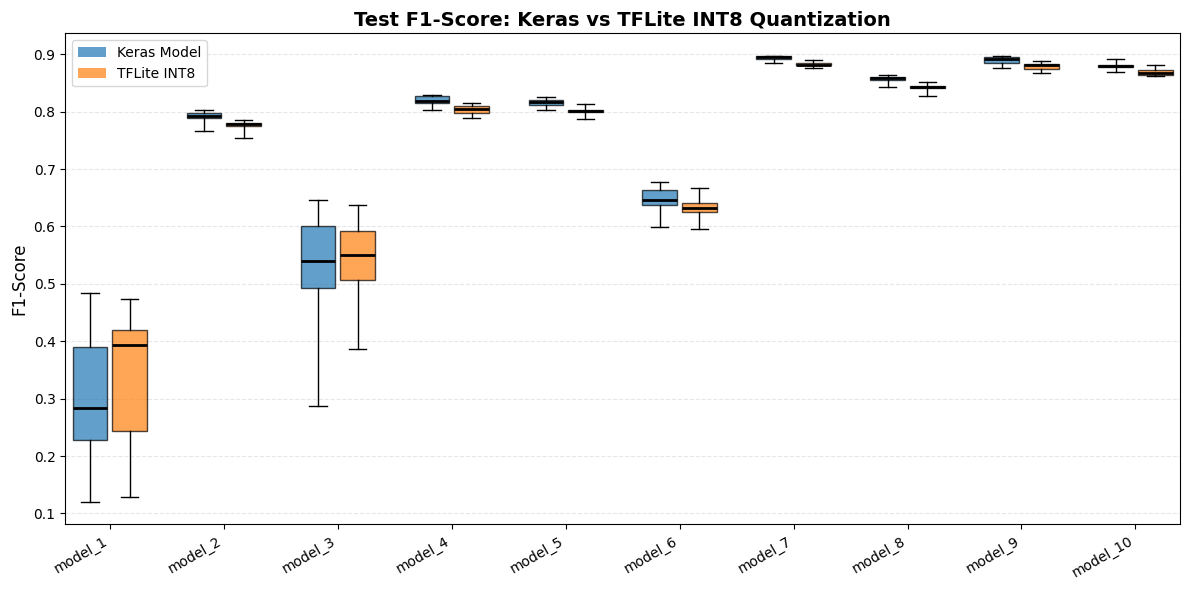

In [63]:
print("3. Comparing Normal Keras vs TFLite INT8 models...")
tflite_int8_cpu_energy = extract_test_cpu_energy_by_model(df_tflite_normal_int8)
tflite_int8_cpu_acc = extract_tflite_accuracy_by_model(df_tflite_normal_int8)
tflite_int8_cpu_f1 = extract_tflite_f1_by_model(df_tflite_normal_int8)

tflite_int8_cpu_energy = reorder_models(tflite_int8_cpu_energy, CUSTOM_ORDER)
tflite_int8_cpu_acc = reorder_models(tflite_int8_cpu_acc, CUSTOM_ORDER)
tflite_int8_cpu_f1 = reorder_models(tflite_int8_cpu_f1, CUSTOM_ORDER)

fig3 = create_side_by_side_comparison(
    normal_test_cpu_energy, tflite_int8_cpu_energy,
    'Keras Model', 'TFLite INT8 (CPU)',
    'Test Energy: Keras vs TFLite INT8 Quantization',
    'Total Energy (Wh)'
)
fig3.savefig(f'{save_dir}/3_keras_vs_tflite_int8_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig3_acc = create_accuracy_boxplot_comparison(
    normal_test_acc, tflite_int8_cpu_acc,
    'Keras Model', 'TFLite INT8',
    'Test Accuracy: Keras vs TFLite INT8 Quantization'
)
fig3_acc.savefig(f'{save_dir}/3_keras_vs_tflite_int8_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

fig3_f1 = create_accuracy_boxplot_comparison(
    normal_test_f1, tflite_int8_cpu_f1,
    'Keras Model', 'TFLite INT8',
    'Test F1-Score: Keras vs TFLite INT8 Quantization',
    ylabel='F1-Score'
)
fig3_f1.savefig(f'{save_dir}/3_keras_vs_tflite_int8_f1.png', dpi=300, bbox_inches='tight')
plt.show()


4. Comparing Fine-tuned Keras vs TFLite Fine-tuned INT8...


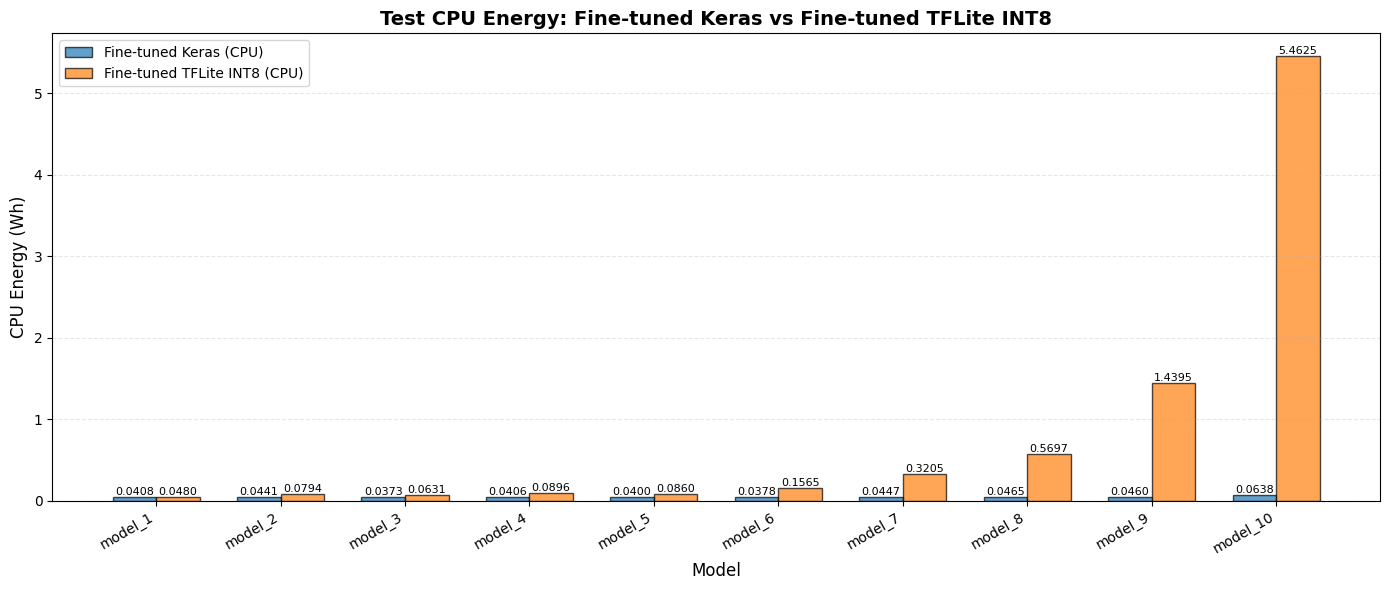

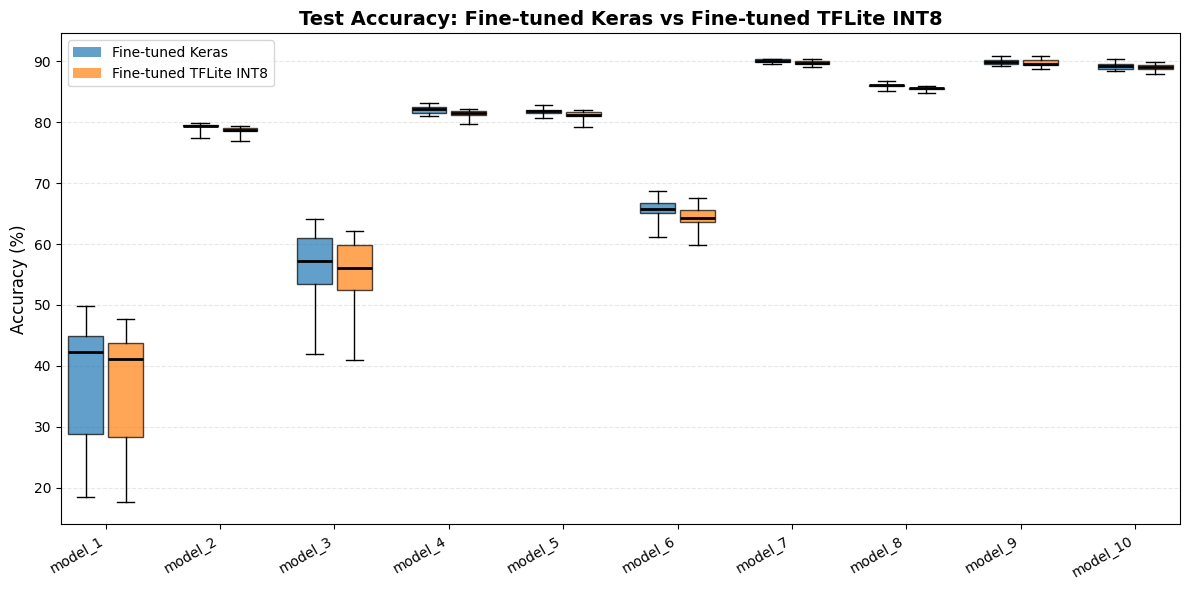

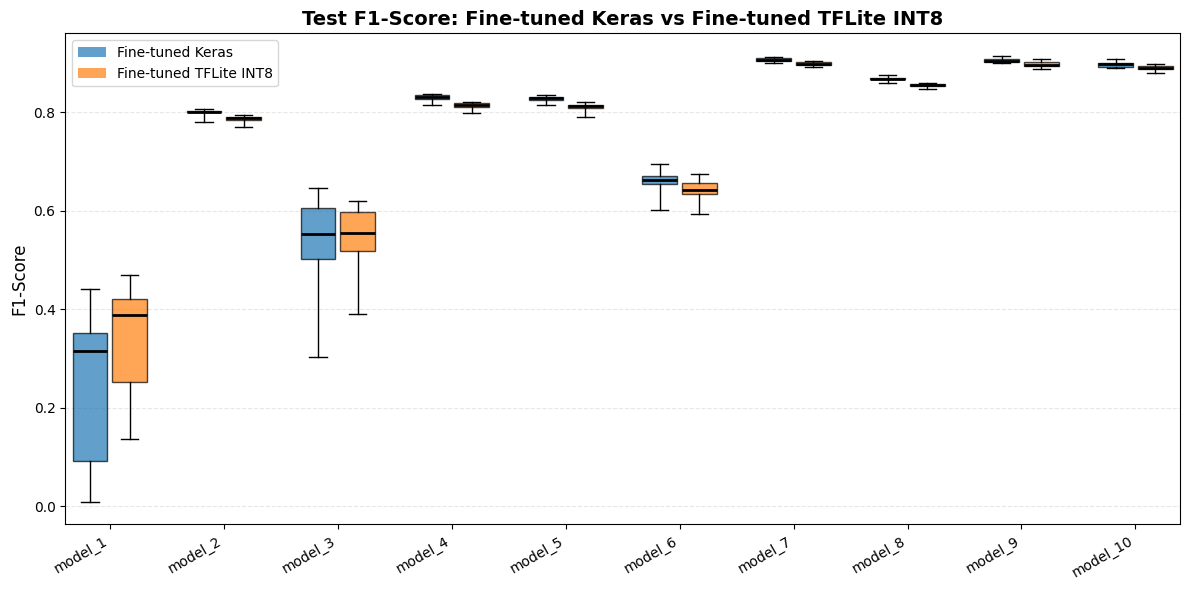

In [64]:
print("4. Comparing Fine-tuned Keras vs TFLite Fine-tuned INT8...")

tflite_finetuned_int8_cpu_energy = extract_test_cpu_energy_by_model(df_tflite_finetuned_int8)
tflite_finetuned_int8_cpu_acc = extract_tflite_accuracy_by_model(df_tflite_finetuned_int8)
tflite_finetuned_int8_cpu_f1 = extract_tflite_f1_by_model(df_tflite_finetuned_int8)

tflite_finetuned_int8_cpu_energy = reorder_models(tflite_finetuned_int8_cpu_energy, CUSTOM_ORDER)
tflite_finetuned_int8_cpu_acc = reorder_models(tflite_finetuned_int8_cpu_acc, CUSTOM_ORDER)
tflite_finetuned_int8_cpu_f1 = reorder_models(tflite_finetuned_int8_cpu_f1, CUSTOM_ORDER)

fig4_energy = create_side_by_side_comparison(
    finetuned_test_cpu_energy, tflite_finetuned_int8_cpu_energy,
    'Fine-tuned Keras (CPU)', 'Fine-tuned TFLite INT8 (CPU)',
    'Test CPU Energy: Fine-tuned Keras vs Fine-tuned TFLite INT8',
    'CPU Energy (Wh)'
)
fig4_energy.savefig(f'{save_dir}/4_finetuned_keras_vs_tflite_int8_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig4_acc = create_accuracy_boxplot_comparison(
    finetuned_test_acc, tflite_finetuned_int8_cpu_acc,
    'Fine-tuned Keras', 'Fine-tuned TFLite INT8',
    'Test Accuracy: Fine-tuned Keras vs Fine-tuned TFLite INT8'
)
fig4_acc.savefig(f'{save_dir}/4_finetuned_keras_vs_tflite_int8_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

fig4_f1 = create_accuracy_boxplot_comparison(
    finetuned_test_f1, tflite_finetuned_int8_cpu_f1,
    'Fine-tuned Keras', 'Fine-tuned TFLite INT8',
    'Test F1-Score: Fine-tuned Keras vs Fine-tuned TFLite INT8',
    ylabel='F1-Score'
)
fig4_f1.savefig(f'{save_dir}/4_finetuned_keras_vs_tflite_int8_f1.png', dpi=300, bbox_inches='tight')
plt.show()

5. Comparing TFLite No-Quant vs INT8 (Normal models)...


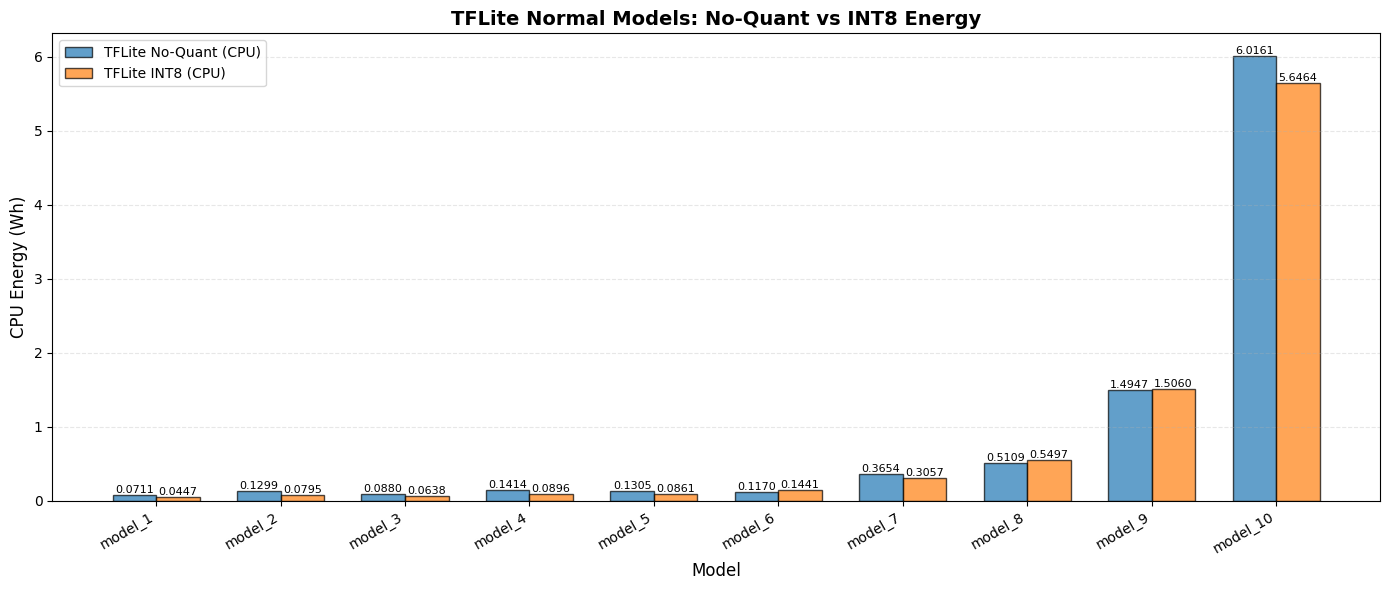

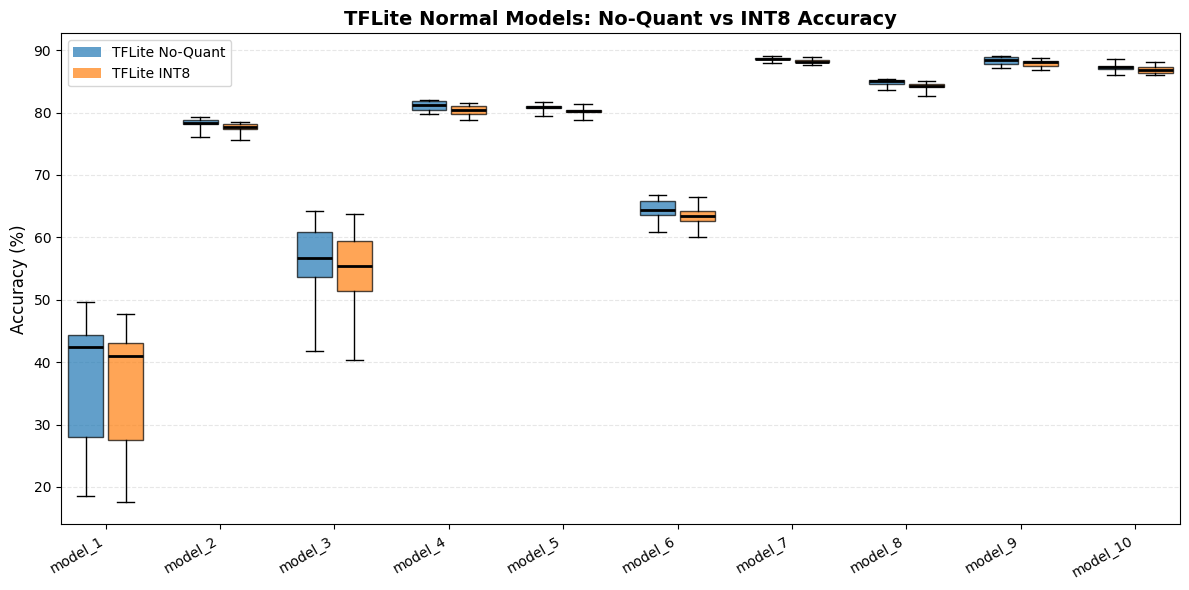

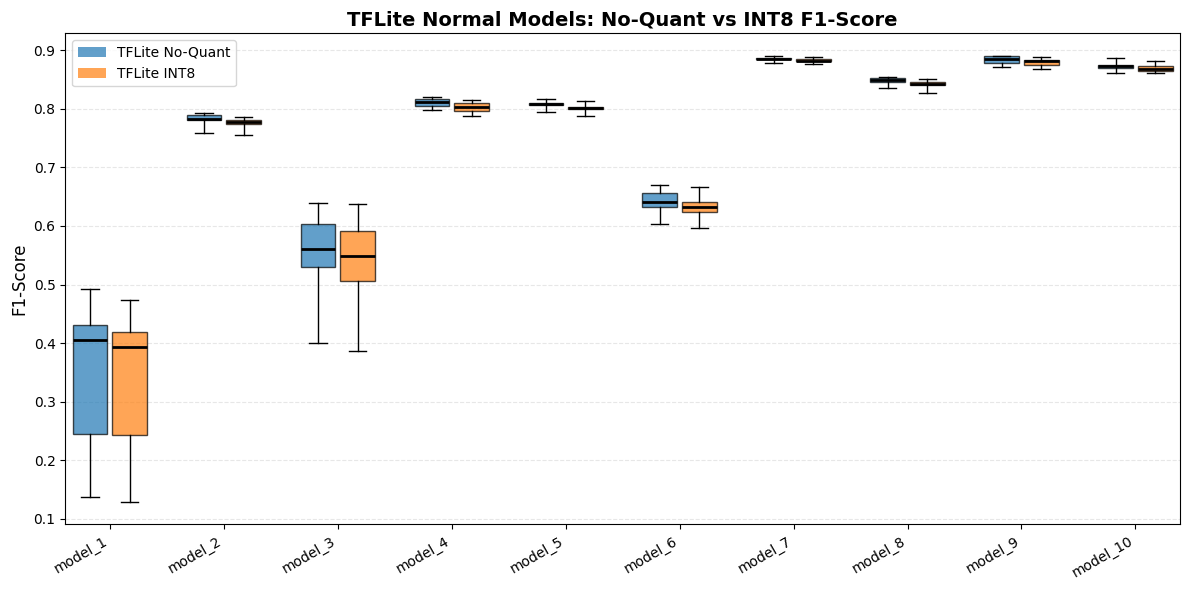

In [65]:
print("5. Comparing TFLite No-Quant vs INT8 (Normal models)...")
fig5_energy = create_side_by_side_comparison(
    tflite_no_quant_cpu_energy, tflite_int8_cpu_energy,
    'TFLite No-Quant (CPU)', 'TFLite INT8 (CPU)',
    'TFLite Normal Models: No-Quant vs INT8 Energy',
    'CPU Energy (Wh)'
)
fig5_energy.savefig(f'{save_dir}/6_tflite_normal_noquant_vs_int8_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig5_acc = create_accuracy_boxplot_comparison(
    tflite_no_quant_cpu_acc, tflite_int8_cpu_acc,
    'TFLite No-Quant', 'TFLite INT8',
    'TFLite Normal Models: No-Quant vs INT8 Accuracy'
)
fig5_acc.savefig(f'{save_dir}/6_tflite_normal_noquant_vs_int8_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

fig5_f1 = create_accuracy_boxplot_comparison(
    tflite_no_quant_cpu_f1, tflite_int8_cpu_f1,
    'TFLite No-Quant', 'TFLite INT8',
    'TFLite Normal Models: No-Quant vs INT8 F1-Score',
    ylabel='F1-Score'
)
fig5_f1.savefig(f'{save_dir}/6_tflite_normal_noquant_vs_int8_f1.png', dpi=300, bbox_inches='tight')
plt.show()

6. Comparing TFLite No-Quant vs INT8 (Fine-tuned models)...


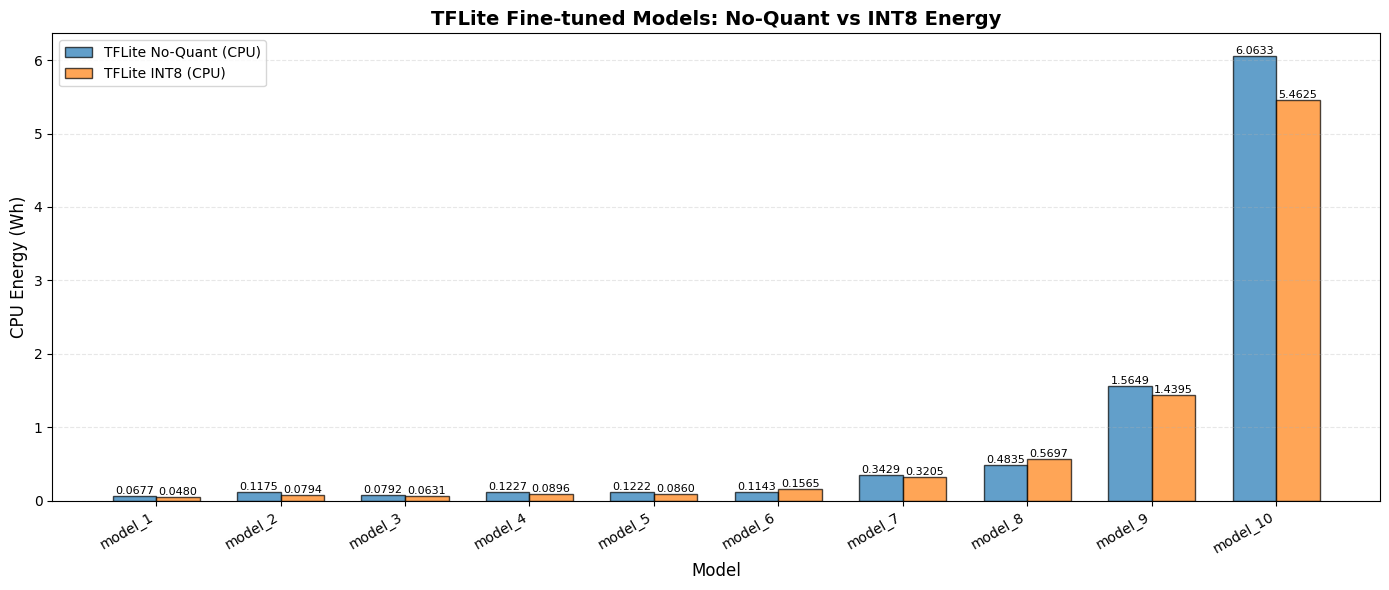

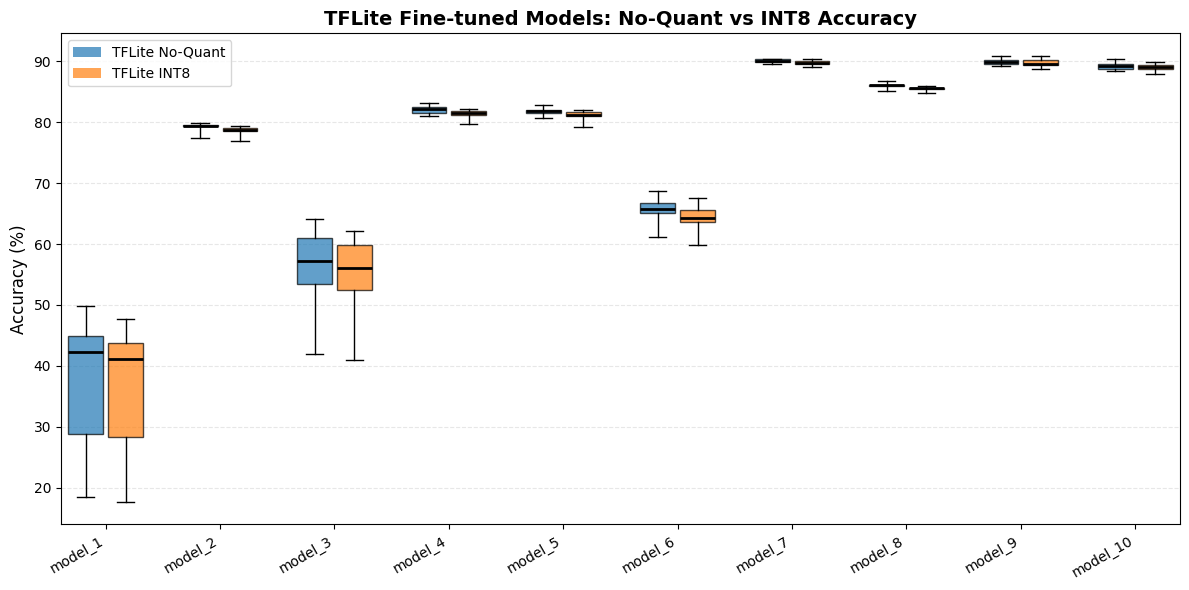

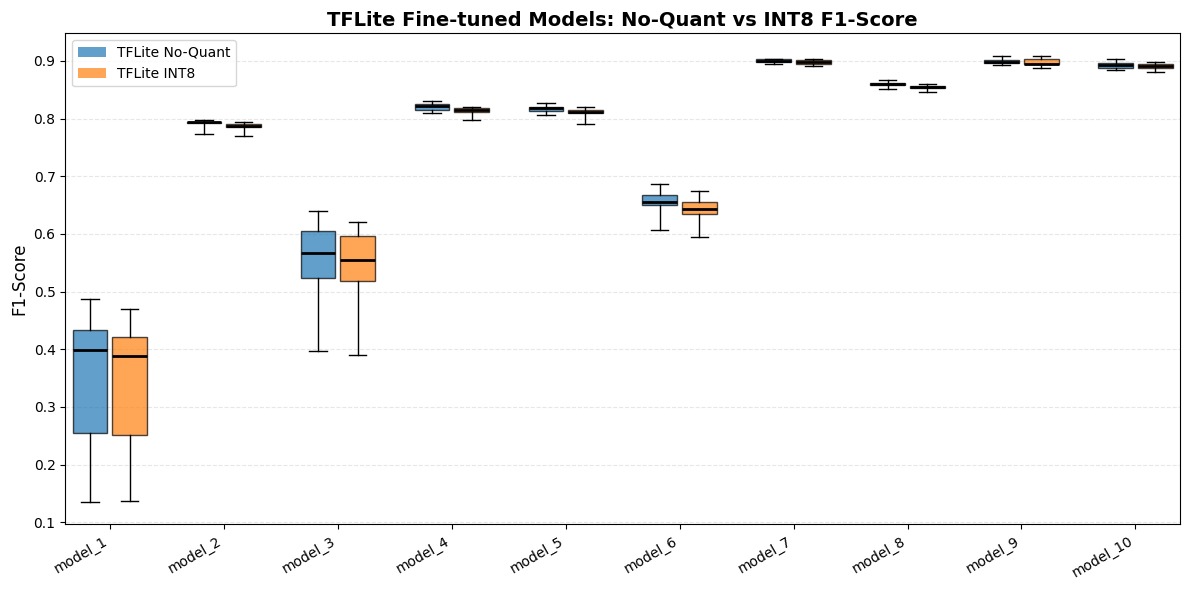

In [66]:
print("6. Comparing TFLite No-Quant vs INT8 (Fine-tuned models)...")

tflite_finetuned_no_quant_cpu_energy = extract_test_cpu_energy_by_model(df_tflite_finetuned_no_quant_cpu)
tflite_finetuned_no_quant_cpu_acc = extract_tflite_accuracy_by_model(df_tflite_finetuned_no_quant_cpu)
tflite_finetuned_int8_cpu_energy = extract_test_cpu_energy_by_model(df_tflite_finetuned_int8)
tflite_finetuned_int8_cpu_acc = extract_tflite_accuracy_by_model(df_tflite_finetuned_int8)
tflite_finetuned_no_quant_cpu_f1 = extract_tflite_f1_by_model(df_tflite_finetuned_no_quant_cpu)
tflite_finetuned_int8_f1 = extract_tflite_f1_by_model(df_tflite_finetuned_int8)

tflite_finetuned_no_quant_cpu_energy = reorder_models(tflite_finetuned_no_quant_cpu_energy, CUSTOM_ORDER)
tflite_finetuned_no_quant_cpu_acc = reorder_models(tflite_finetuned_no_quant_cpu_acc, CUSTOM_ORDER)
tflite_finetuned_int8_cpu_energy = reorder_models(tflite_finetuned_int8_cpu_energy, CUSTOM_ORDER)
tflite_finetuned_int8_cpu_acc = reorder_models(tflite_finetuned_int8_cpu_acc, CUSTOM_ORDER)
tflite_finetuned_no_quant_cpu_f1 = reorder_models(tflite_finetuned_no_quant_cpu_f1, CUSTOM_ORDER)
tflite_finetuned_int8_f1 = reorder_models(tflite_finetuned_int8_f1, CUSTOM_ORDER)

fig6_energy = create_side_by_side_comparison(
    tflite_finetuned_no_quant_cpu_energy, tflite_finetuned_int8_cpu_energy,
    'TFLite No-Quant (CPU)', 'TFLite INT8 (CPU)',
    'TFLite Fine-tuned Models: No-Quant vs INT8 Energy',
    'CPU Energy (Wh)'
)
fig6_energy.savefig(f'{save_dir}/7_tflite_finetuned_noquant_vs_int8_energy.png', dpi=300, bbox_inches='tight')
plt.show()

fig6_acc = create_accuracy_boxplot_comparison(
    tflite_finetuned_no_quant_cpu_acc, tflite_finetuned_int8_cpu_acc,
    'TFLite No-Quant', 'TFLite INT8',
    'TFLite Fine-tuned Models: No-Quant vs INT8 Accuracy'
)
fig6_acc.savefig(f'{save_dir}/7_tflite_finetuned_noquant_vs_int8_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

fig6_f1 = create_accuracy_boxplot_comparison(
    tflite_finetuned_no_quant_cpu_f1, tflite_finetuned_int8_f1,
    'TFLite No-Quant', 'TFLite INT8',
    'TFLite Fine-tuned Models: No-Quant vs INT8 F1-Score',
    ylabel='F1-Score'
)
fig6_f1.savefig(f'{save_dir}/7_tflite_finetuned_noquant_vs_int8_f1.png', dpi=300, bbox_inches='tight')
plt.show()